In [1]:
from quspin.operators import hamiltonian, commutator, anti_commutator
from quspin.basis import spinful_fermion_basis_1d
from quspin.tools.evolution import evolve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
def rhs(tau, phi, h):
    """
    RHS of imaginary time propagation of phi
    :param tau: imaginary time
    :param phi: wavefunction
    :param h:   hamiltonian
    :return:
    """
    return -h.dot(phi)

In [3]:
def get_energy_gap(ham, obs, wf):
    """
    Calculates the energy gap as <wf|[ham, obs]_3|wf>/<wf|[ham, obs]_1|wf>
    :param ham: hamiltonian
    :param obs: observable - just need to overlap gs and 1st excited state
    :param wf:  wavefunction from imaginary time propagation
    :return:    the energy gap
    """
    # Calculate commutators
    sing_comm = commutator(ham, obs)
    trip_comm = commutator(ham, commutator(ham, sing_comm))

    return trip_comm.expt_value(wf) / sing_comm.expt_value(wf)

In [4]:
def alt_get_energy_gap(ham, obs, wf):
    """
    Calculate the energy gap as <wf|[ham, obs]_4|wf>/<wf|[ham, obs]_2|wf>
    :param args:
    :return:
    """
    # Calculate commutators
    sing_comm = commutator(ham, obs)
    doub_comm = commutator(ham, sing_comm)
    quad_comm = commutator(ham, commutator(ham, doub_comm))

    return quad_comm.expt_value(wf) / doub_comm.expt_value(wf)

In [5]:
# Define plotting parameters
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
# Set the random seed
np.random.seed(64)

In [7]:
# Define FH model parameters
L = 4
J = 1
U = np.sqrt(2)

# Define number of up and down fermions
N_up = L // 2 + L % 2
N_down = L // 2

# Define basis
basis = spinful_fermion_basis_1d(L, Nf=(N_up, N_down))

In [8]:
# Define site-coupling lists
hop_right = [[-J, i, (i+1) % L] for i in range(L-1)]  # APBC
hop_left = [[+J, i, (i+1) % L] for i in range(L-1)]  # APBC
interact = [[U, i, i] for i in range(L)]  # U/2 \sum_j n_{j, up} n_{j_down}

In [9]:
# Define static and dynamic lists
static = [
    ['+-|', hop_left],      # up hops left
    ['-+|', hop_right],     # up hops right
    ['|+-', hop_left],      # down hops left
    ['|-+', hop_right],     # down hops right
    ['n|n', interact]       # up-down interaction
]

dynamic = []

In [10]:
# Build Hamiltonian
H = hamiltonian(static, dynamic, basis=basis, check_symm=False)

# Get eigenvalues and eigenvectors
E, V = H.eigh()

# Need to introduce offset to avoid negative energies in unnormalized imaginary time
# evolution
mu = 1.1*E[0] / L
pot=[[-mu,i] for i in range(L)]
static = [
    ['n|',pot],        # up on-site potention
    ['|n',pot],        # down on-site potention
    ['+-|', hop_left],      # up hops left
    ['-+|', hop_right],     # up hops right
    ['|+-', hop_left],      # down hops left
    ['|-+', hop_right],     # down hops right
    ['n|n', interact]       # up-down interaction
]

# Create shifted Hamiltonian
Hp = hamiltonian(static, dynamic, basis=basis, check_symm=False)

# Get shifted eigenenergies and eigenvectors
Ep, Vp = Hp.eigh()

# Calculate the exact gap squared for future comparison
exact_gap_squared = (E[0] - E[1]) ** 2
pexact_gap_squared = (Ep[0] - Ep[1]) ** 2
print("")
print("Shifted gap squared equals exact gap squared? ", 
      np.allclose(exact_gap_squared, pexact_gap_squared))

# Get the ground and first excited states of shifted H for checking the overlap of O
gs = Vp[:, 0]
fst_exc = Vp[:, 1]

Hermiticity check passed!
Particle conservation check passed!
Hermiticity check passed!
Particle conservation check passed!

Shifted gap squared equals exact gap squared?  True


In [11]:
# Generate random initial state
phi0 = np.random.random(gs.shape[0]) + 1j*np.random.random(gs.shape[0])
phi0 /= np.sqrt(np.sum(abs(phi0) ** 2))

# Check that phi0 has support on ground and first excited states
print("gs dot phi0: ", gs.conj().T @ phi0)
print("fst_exc dot phi0: ", fst_exc.conj().T @ phi0)

# Set up imaginary time evolution
tau_inc = np.linspace(0, 15, 1000)

gs dot phi0:  (0.07646818402945764-0.007202562641995847j)
fst_exc dot phi0:  (-0.018585675149970934-0.056117691013960164j)


In [12]:
# Evolve state
psi_gen = evolve(phi0, tau_inc[0], tau_inc, rhs, f_params=(Hp,), imag_time=False, iterate=True)
psi = np.array([_ for _ in psi_gen])

Text(0, 0.5, 'Norm of $\\psi$')

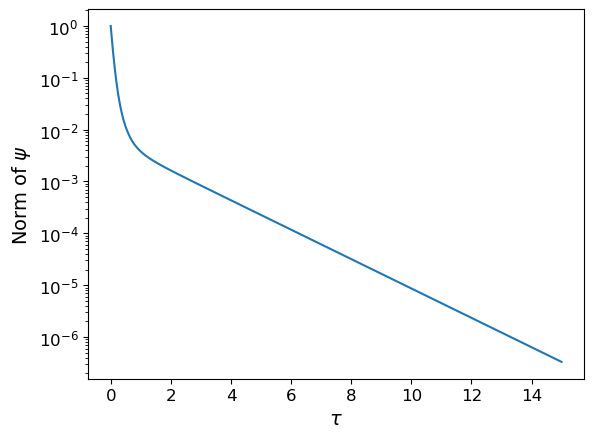

In [13]:
# Check normalization of each psi
norm_factor = [np.sum(abs(_) ** 2) for _ in psi]
plt.semilogy(tau_inc, norm_factor)
plt.xlabel("$\\tau$")
plt.ylabel("Norm of $\\psi$")
#plt.ylim([0, 1.1])

In [14]:
# Define observable to use
obs_int = [[1, 0, 1]]
obs_static = [
    ["n|n", obs_int]
]
obs_dynamic = []
obs = hamiltonian(obs_static, obs_dynamic, basis=basis, check_symm=False)

# Calculate the single and triple commutators
sing_comm = commutator(H, obs)
trip_comm = commutator(H, commutator(H, sing_comm))

# Verify that observable is good
print("Does O overlap first 2 states?", 
      not np.allclose(fst_exc.conj().T @ obs.toarray() @ gs, 0))
print("[H, O]_1 == 0?", 
      np.allclose(sing_comm.toarray(), np.zeros((gs.shape[0], gs.shape[0]))))
print("[H, 0]_3 == 0?",
     np.allclose(trip_comm.toarray(), np.zeros((gs.shape[0], gs.shape[0]))))

Hermiticity check passed!
Particle conservation check passed!
Does O overlap first 2 states? True
[H, O]_1 == 0? False
[H, 0]_3 == 0? False


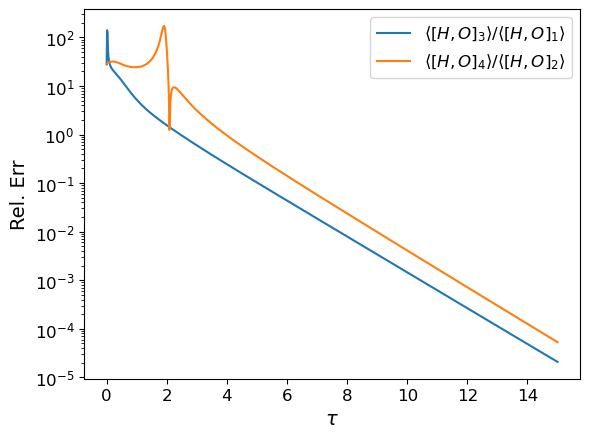

In [15]:
# Calculate energy gap vs tau
calc_gap_sq = np.array([get_energy_gap(H, obs, _) for _ in psi])
alt_gap_sq = np.array([alt_get_energy_gap(H, obs, _) for _ in psi])

# Calculate relative errors
rel_err = abs(exact_gap_squared - calc_gap_sq) / exact_gap_squared
alt_rel_err = abs(exact_gap_squared - alt_gap_sq) / exact_gap_squared
plt.semilogy(tau_inc, rel_err, 
             label='$\\langle[H, O]_3\\rangle / \\langle[H, O]_1\\rangle$')
plt.semilogy(tau_inc, alt_rel_err, 
             label='$\\langle[H, O]_4\\rangle / \\langle[H, O]_2\\rangle$')
plt.xlabel("$\\tau$")
plt.ylabel("Rel. Err")
plt.legend(numpoints=1)

In [16]:
# Attempt to calculate E1-E2 gap from slope
# Don't want to start at tau=0 and want to end before error stops being linear in log scale
# Get E1-E2 gap
e12_gap = E[1]-E[2]
print("E1-E2 = ", e12_gap)

indx = tau_inc > 5

log_rel_err = np.log(rel_err[indx])
alt_log_rel_err = np.log(alt_rel_err[indx])

reg = LinearRegression().fit(
        tau_inc[indx].reshape(-1, 1),
        log_rel_err.reshape(-1, 1)
    )

alt_reg = LinearRegression().fit(
        tau_inc[indx].reshape(-1, 1),
        alt_log_rel_err.reshape(-1, 1)
    )

# Print slopes
print("===== M = 3, 1 =====")
print("E1-E2 from slope: ", reg.coef_)
print("Relative error: ", np.abs(reg.coef_ - e12_gap) / -e12_gap)
print("===== M = 4, 2 =====")
print("E1-E2 from slope: ", alt_reg.coef_)
print("Relative error: ", np.abs(alt_reg.coef_ - e12_gap) / -e12_gap)

E1-E2 =  -0.8362504747749506
===== M = 3, 1 =====
E1-E2 from slope:  [[-0.8503714]]
Relative error:  [[0.016886]]
===== M = 4, 2 =====
E1-E2 from slope:  [[-0.877977]]
Relative error:  [[0.04989716]]


In [17]:
# Attempt to calculate the spectral gap from the slope of <[H, O]_1> and expectation of H
sing_comm_expt_vals = np.array([sing_comm.expt_value(_) for _ in psi])
log_expt_vals = np.log(abs(sing_comm_expt_vals))

indx = tau_inc > 5
sing_comm_reg = LinearRegression().fit(
    tau_inc[indx].reshape(-1, 1),
    log_expt_vals[indx].reshape(-1, 1)
)

# Should be equal to E0 + E1
spectral_sum = Ep[0] + E[1]
print("E0 + E1 = ", spectral_sum)
print("Slope of ln|<[H, O]_1>|: ", sing_comm_reg.coef_)
print("Relative error: ", np.abs(spectral_sum - sing_comm_reg.coef_) / spectral_sum)

print("Ep0 + Ep1 = ", Hp_sum)
print("Slope of ln|<[H, O]_1>|: ", sing_comm_reg.coef_)
print("Relative error: ", np.abs(Hp_sum - -sing_comm_reg.coef_) / Hp_sum)

E0 + E1 =  -5.632598470957781
Slope of ln|<[H, O]_1>|:  [[-1.54764892]]
Relative error:  [[-0.72523358]]
Ep0 + Ep1 =  1.5457104362173908
Slope of ln|<[H, O]_1>|:  [[-1.54764892]]
Relative error:  [[0.0012541]]


Text(0, 0.5, 'Ln|<[H, O]_1>|')

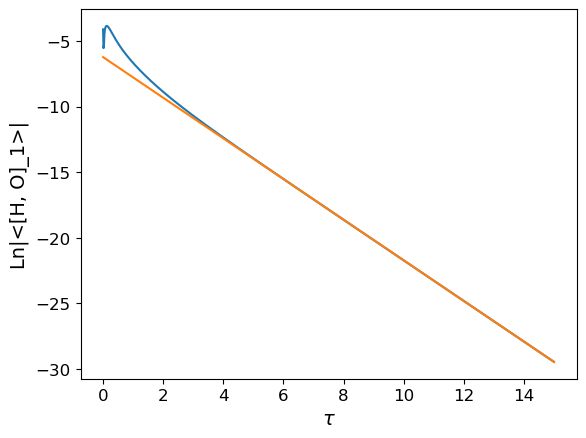

In [18]:
plt.plot(tau_inc, log_expt_vals, label='Calculated')
plt.plot(tau_inc, sing_comm_reg.predict(tau_inc.reshape(-1, 1)))
plt.xlabel("$\\tau$")
plt.ylabel("Ln|<[H, O]_1>|")